# Etude statistique du dataset
Lien vers le dataset que nous avons choisi :


Le but de faire une étude statistique sur le dataset choisi est d'établir quel sous-set est exploitable afin d'entrainer et évaluer un modèle de CNN pour la classification d'images. Si aucun sous-set n'est exploitable en l'état car trop peu équilibré entre les différentes classes de styles architecturaux, alors nous pourrons agréger certains sous-sets afin d'équilibrer les données que l'on souhaite exploiter.

Installation des package python nécessaires :

In [1]:
# Installation des librairies nécessaires :
! pip install pandas
! pip install matplotlib
! pip install pillow

In [2]:
# On transforme tous les .txt du dossier ../sets/ en .csv :
import csv
import os

# les fichiers textes ont la structure suivante :
# {nom du fichier image} {classe de l'image}
# Ne pas oublier de mettre un espace entre les deux

# Les fichiers sont dans le dossier ../sets/txt/
# On les convertit en .csv dans le dossier ../sets/csv/

path = "../sets/txt/"
path_csv = "../sets/csv/"

for filename in os.listdir(path):
    with open(path + filename, 'r') as txt_file:
        stripped = (line.strip() for line in txt_file)
        lines = (line.split(" ") for line in stripped if line)
        with open(path_csv + filename + '.csv', 'w') as csv_file:
            writer = csv.writer(csv_file,lineterminator = '\n')
            writer.writerows(lines)

In [3]:
# On fait de même pour :
parent_child_rel = '../dataset_doc/txt/parent_child_rel.txt'
style_names = '../dataset_doc/txt/style_names.txt'

parent_child_rel_csv = '../dataset_doc/csv/parent_child_rel.csv'
style_names_csv = '../dataset_doc/csv/style_names.csv'

with open(parent_child_rel, 'r') as txt_file:
    stripped = (line.strip() for line in txt_file)
    lines = (line.split(" ") for line in stripped if line)
    with open(parent_child_rel_csv, 'w') as csv_file:
        writer = csv.writer(csv_file,lineterminator = '\n')
        writer.writerows(lines)

# Dans le fichier style_names.txt, il y a des espaces dans les noms de style.
# On sépare donc juste après le premier espace.

with open(style_names, 'r') as txt_file:
    stripped = (line.strip() for line in txt_file)
    lines = (line.split(" ",1) for line in stripped if line)
    with open(style_names_csv, 'w') as csv_file:
        writer = csv.writer(csv_file,lineterminator = '\n')
        writer.writerows(lines)

In [4]:
# On a un fichier de csv parent_child_rel.csv contenant des informations les informations suivantes :
# {id du style architectural parent} {id du style architectural enfant}

# On a un autre fichier style_names.csv contenant :
# {id du style architectural} {nom du style architectural}

# On souhaite créer un dataframe contenant :
# -id du style architectural parent
# -nom du style architectural parent
# -id du style architectural enfant
# -nom du style architectural enfant

parent_child_rel_csv = '../dataset_doc/csv/parent_child_rel.csv'
style_names_csv = '../dataset_doc/csv/style_names.csv'

import pandas as pd

def get_parent_child_rel(rel_file, names_file):
    df_rel = pd.read_csv(rel_file, names = ['parent_id', 'child_id'])

    df_names = pd.read_csv(names_file, names = ['style_id', 'name_style'])
    

    # Pour chaque ligne du dataframe df_rel, on cherche le nom du style architectural parent et enfant dans df_names
    # On ajoute ensuite ces informations dans df_rel

    df_rel['parent_name'] = df_rel['parent_id'].apply(lambda x: df_names[df_names['style_id'] == x]['name_style'].values[0])
    df_rel['child_name'] = df_rel['child_id'].apply(lambda x: df_names[df_names['style_id'] == x]['name_style'].values[0])


    # On réorganise les colonnes pour avoir :
    df_rel = df_rel[['parent_id', 'parent_name', 'child_id', 'child_name']]

    return df_rel
    
    


In [5]:
# On crée un dataframe contenant les relations parent-enfant
df_rel = get_parent_child_rel(parent_child_rel_csv, style_names_csv)
display(df_rel.head())
display(df_rel.tail())

,parent_id,parent_name,child_id,child_name
0,Q750752,English Gothic,Q578577,Early English Gothic
1,Q176483,Gothic,Q3111491,Meridional Gothic
2,Q236122,Renaissance,Q3399545,Spanish Renaissance
3,Q840829,Baroque,Q6092662,Italian Baroque
4,Q46261,Romanesque,Q2884586,Italian Romanesque Architecture


,parent_id,parent_name,child_id,child_name
50,Q1810654,Serbo-Byzantine Architecture,Q3501300,Serbo-Byzantine Style (modern architecture)
51,Q46261,Romanesque,Q744373,Romanesque Revival Architecture
52,Q236122,Renaissance,Q502163,Renaissance Revival Architecture
53,Q4198718,Classical Architecture,Q54111,Neoclassical Architecture
54,Q840829,Baroque,Q21564105,Rococo


On observe les relations entre les classes (enfants) et super-classes (parents) de style architecturaux.
Car il existe énorméement de classes/styles différents, nous n'utiliseront dans la suite de l'exercice que les super-classes (parents) de style architecturaux comme `Gothic`, `Renaissance`, `Byzantine`...

## Etude statistique

Chemins vers les différents jeux présents dans le dataset.
On en dénombre 4 :

| Nom | Détail |
| - | - |
| wc4 | Jeu de données limité à 4 classes (Gothic,Renaissance,Romanesque,Baroque) |
| wc6 | Jeu de données contenant les 6 plus grandes classes possédant plus de 200 images d'un type d'église |
| wc14 | Comprend les 14 classes du dataset. Ce set couvre 94% des images |
| wch | Ce set permet d'étudier les liens de parenté entre les styles. Nous ne nous en serviront donc pas |

Note : _Le jeu wc4 est un sous-jeu du wc6. Ces deux jeux possèdent 4 split (training,test,train_eval,eval)._

Note 2 : _Chaque fichier texte des sous-sets contient le nom du fichier image et l'ID du style architectural associé, sous la nomenclature Q+{suite de chiffres unique}_.

### Définition des fonctions utilisées :

_Get_img_parent_style_ permet de lier dans un dataframe une image d'un sous-set avec l'ID de son style et le `label` du style.

In [6]:
# On créé une fonction qui prend en argument un fichier texte et qui retourne un dataframe contenant :
# -le nom du fichier image
# -l'id du style architectural lié

def get_img_parent_style(csv_file):
    # On lit le fichier csv 
    df_in = pd.read_csv(csv_file, names = ['img_name', 'parent_id'])


    # On renomme la colonne index en img_name
    df_in = df_in.rename(columns={'index':'img_name'})

    

    # On cherche le nom du style architectural parent dans df_rel et on l'ajoute dans df_in
    df_in['parent_name'] = df_in['parent_id'].apply(lambda x: df_rel[df_rel['parent_id'] == x]['parent_name'].values[0])
    display(df_in.head())
    display(df_in.shape)
    # On retourne le dataframe
    return df_in

*Plot_style_distribution* permet d'observer la distribution des super-classes (styles parents) dans un sous-set.

In [7]:
# On souhaite visualiser la distribution des styles architecturaux dans les différents sets
import matplotlib.pyplot as plt

# On souhaite aussi visualiser le nombre exact d'images par style architectural
def plot_style_distribution(df, set_name):
    # On crée un dictionnaire contenant le nombre d'images par style architectural
    style_count = df['parent_name'].value_counts().to_dict()

    # On crée un dataframe à partir du dictionnaire
    df_count = pd.DataFrame.from_dict(style_count, orient='index',columns=['count']).reset_index()
    # On renomme la colonne index en style_name
    df_count = df_count.rename(columns={'index':'style_name'})

    # On trie le dataframe par ordre décroissant
    df_count = df_count.sort_values(by='count', ascending=False)

    

    # On affiche le nombre d'images par style architectural sous forme de diagramme en bâtons
    plt.figure(figsize=(10,5))

    # On affiche dans la légende le nombre d'images par style architectural
    for i in range(len(df_count)):
        plt.text(i, df_count['count'][i], df_count['count'][i], ha='center', va='bottom')

    plt.bar(df_count['style_name'], df_count['count'])
    plt.title(f'Number of images per architectural style in {set_name} set')
    plt.xticks(rotation=90)
    plt.show()

La classe Subset implémente les fonctions précédentes afin de réaliser une étude statistique à partir d'un document texte (jeu de données) et retourne un dataframe exploitable contenant :
- Le nom de l'image
- L'ID du style associé
- Le label du style associé

In [8]:
#La classe Subset implémente les fonctions précédentes afin de réaliser une étude statistique à partir d'un document texte (jeu de données) et retourne un dataframe exploitable contenant :
#- Le nom de l'image
#- L'ID du style associé
#- Le label du style associé

class Subset:
    def __init__(self, txt_file, set_name):
        self.txt_file = txt_file
        self.set_name = set_name
        self.df = get_img_parent_style(txt_file)
        self.plot_style_distribution()

    def plot_style_distribution(self):
        plot_style_distribution(self.df, self.set_name)

    def get_df(self):
        return self.df

### On étudie statistiquement le jeu WC4

Chemin des fichiers :

In [9]:
test_txt = '../sets/csv/wc4_test.txt.csv'
train_txt = '../sets/csv/wc4_train.txt.csv'
trainval_txt = '../sets/csv/wc4_trainval.txt.csv'
val_txt = '../sets/csv/wc4_val.txt.csv'

# Chacun des fichiers texte ci-dessus contient :
#{nom du fichier image} {id du style architectural enfant}

Initialisation des Subsets et étude statistique :

,img_name,parent_id,parent_name
0,Q2588857_wd0.jpg,Q840829,Baroque
1,Q626388_wd0.jpg,Q840829,Baroque
2,Q11985244_wd0.jpg,Q840829,Baroque
3,Q1561401_wd0.jpg,Q840829,Baroque
4,Q8406909_wd0.jpg,Q840829,Baroque


(1482, 3)

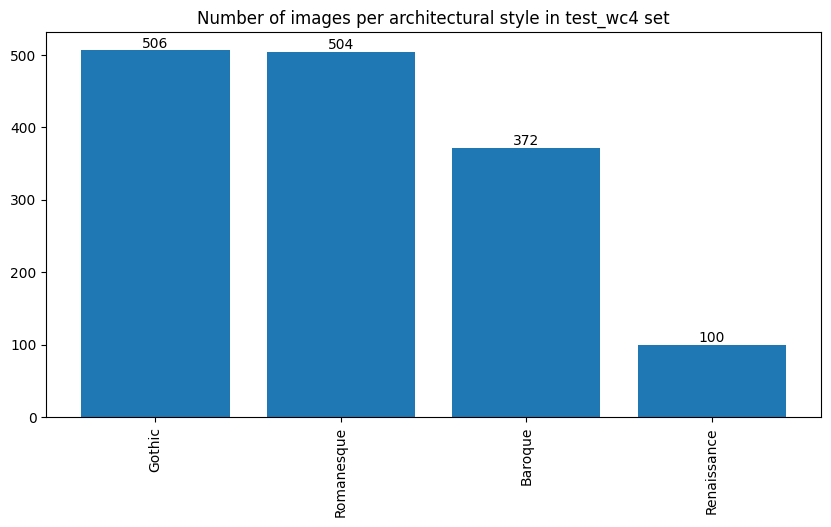

,img_name,parent_id,parent_name
0,Q21716735_wd0.jpg,Q840829,Baroque
1,Q20730233_wd0.jpg,Q840829,Baroque
2,Q2317509_wd0.jpg,Q840829,Baroque
3,Q1897745_wd0.jpg,Q840829,Baroque
4,Q20754132_wd0.jpg,Q840829,Baroque


(5838, 3)

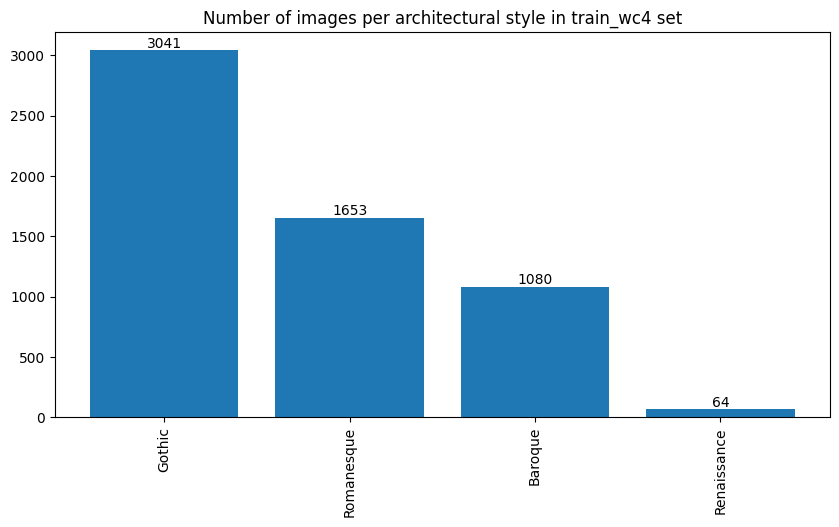

,img_name,parent_id,parent_name
0,Q1415669_wd1.jpg,Q840829,Baroque
1,Q12030410_wd0.jpg,Q840829,Baroque
2,Q12031051_wd0.jpg,Q840829,Baroque
3,Q16320906_wd1.jpg,Q840829,Baroque
4,Q223413_wd0.jpg,Q840829,Baroque


(6044, 3)

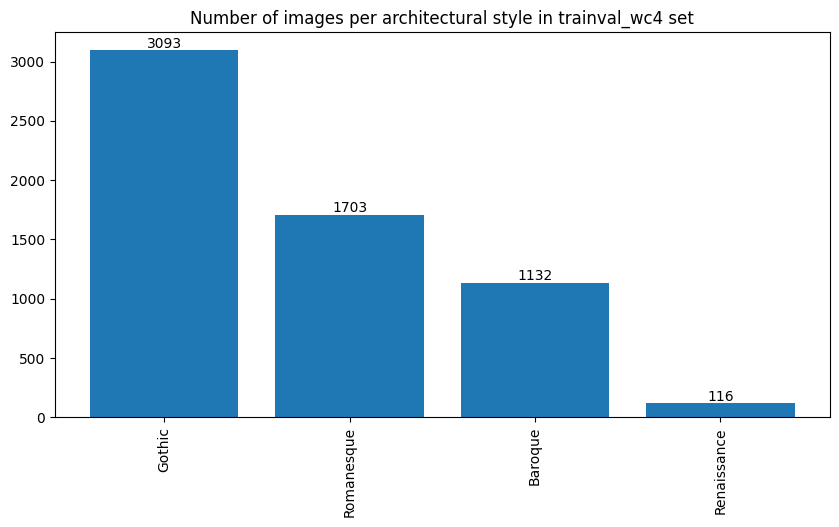

,img_name,parent_id,parent_name
0,Q1415669_wd1.jpg,Q840829,Baroque
1,Q12030410_wd0.jpg,Q840829,Baroque
2,Q12031051_wd0.jpg,Q840829,Baroque
3,Q16320906_wd1.jpg,Q840829,Baroque
4,Q223413_wd0.jpg,Q840829,Baroque


(206, 3)

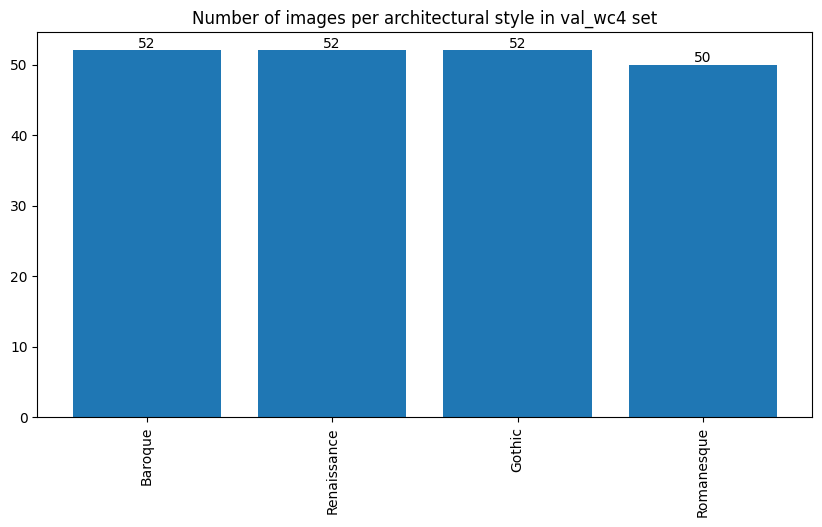

In [10]:
# On crée un objet Subset pour chaque fichier texte
test = Subset(test_txt, 'test_wc4')
train = Subset(train_txt, 'train_wc4')
trainval = Subset(trainval_txt, 'trainval_wc4')
val = Subset(val_txt, 'val_wc4')

In [11]:
display(test.get_df().head())

,img_name,parent_id,parent_name
0,Q2588857_wd0.jpg,Q840829,Baroque
1,Q626388_wd0.jpg,Q840829,Baroque
2,Q11985244_wd0.jpg,Q840829,Baroque
3,Q1561401_wd0.jpg,Q840829,Baroque
4,Q8406909_wd0.jpg,Q840829,Baroque


Etude statistique entière du sous-set `wc4` (on agrège tous les jeux de données).

In [12]:
# On regroupe tous les sets dans un seul dataframe
df_concat_sets = pd.concat([test.get_df(), train.get_df(), trainval.get_df(), val.get_df()], ignore_index=True)
#display(df_concat_sets.head())

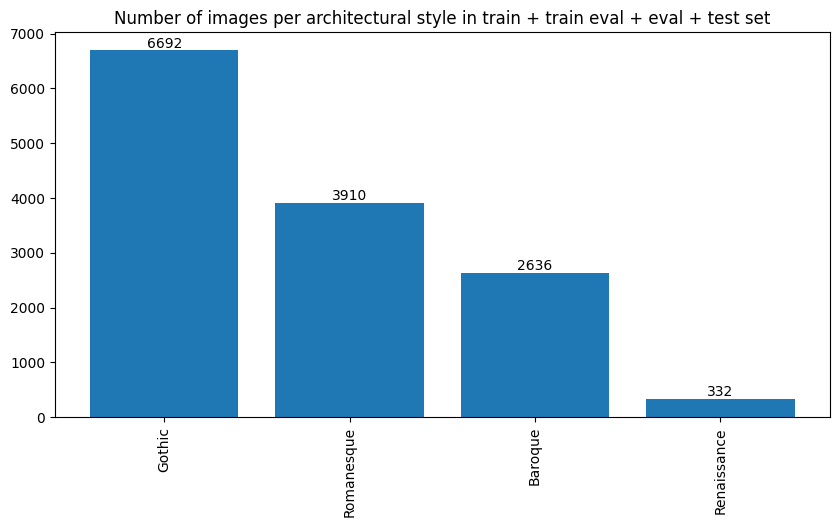

In [13]:
# On souhaite visualiser la distribution des styles architecturaux dans tous les sets
plot_style_distribution(df_concat_sets, 'train + train eval + eval + test')


### Etude statistique du set WC6

In [14]:
# Chemin vers les sets wc6
test_txt = '../sets/csv/wc6_test.txt.csv'
train_txt = '../sets/csv/wc6_train.txt.csv'
trainval_txt = '../sets/csv/wc6_trainval.txt.csv'
val_txt = '../sets/csv/wc6_val.txt.csv'

,img_name,parent_id,parent_name
0,Q2588857_wd0.jpg,Q840829,Baroque
1,Q626388_wd0.jpg,Q840829,Baroque
2,Q11985244_wd0.jpg,Q840829,Baroque
3,Q1561401_wd0.jpg,Q840829,Baroque
4,Q8406909_wd0.jpg,Q840829,Baroque


(1722, 3)

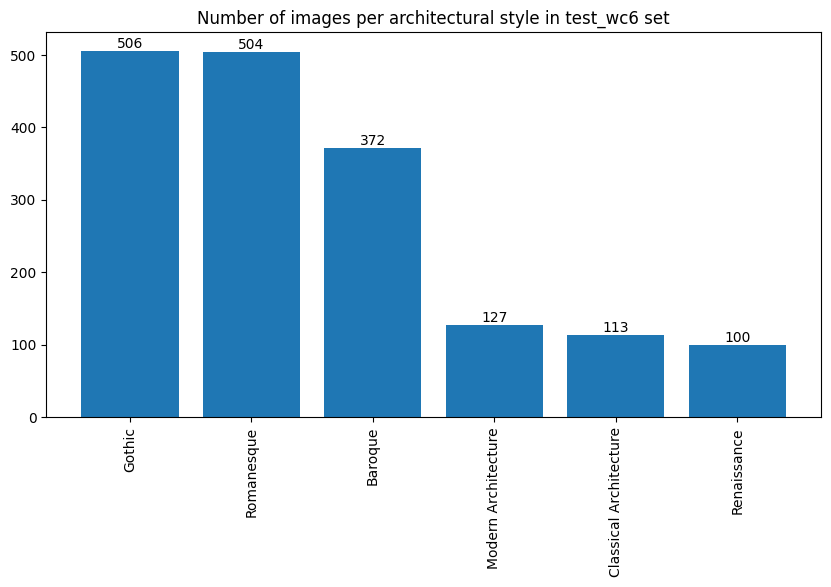

,img_name,parent_id,parent_name
0,Q21716735_wd0.jpg,Q840829,Baroque
1,Q20730233_wd0.jpg,Q840829,Baroque
2,Q2317509_wd0.jpg,Q840829,Baroque
3,Q1897745_wd0.jpg,Q840829,Baroque
4,Q20754132_wd0.jpg,Q840829,Baroque


(6460, 3)

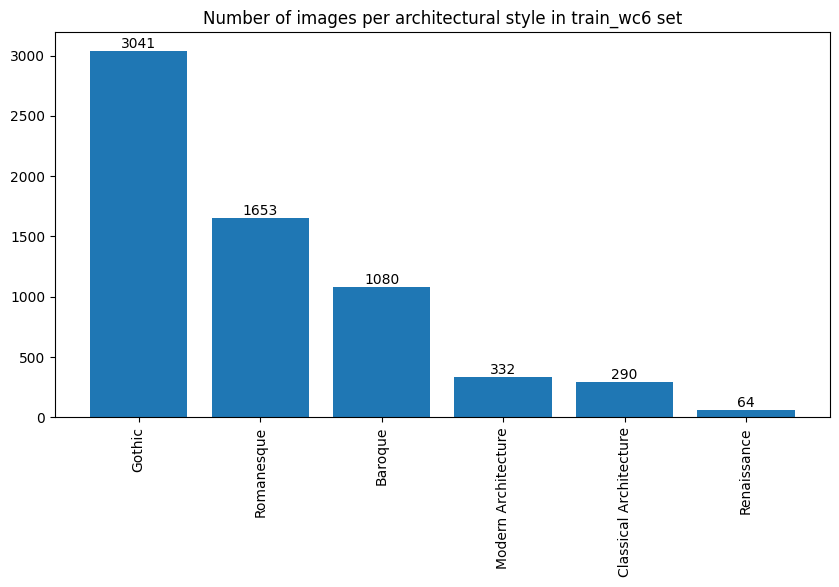

,img_name,parent_id,parent_name
0,Q1415669_wd1.jpg,Q840829,Baroque
1,Q12030410_wd0.jpg,Q840829,Baroque
2,Q12031051_wd0.jpg,Q840829,Baroque
3,Q16320906_wd1.jpg,Q840829,Baroque
4,Q223413_wd0.jpg,Q840829,Baroque


(6766, 3)

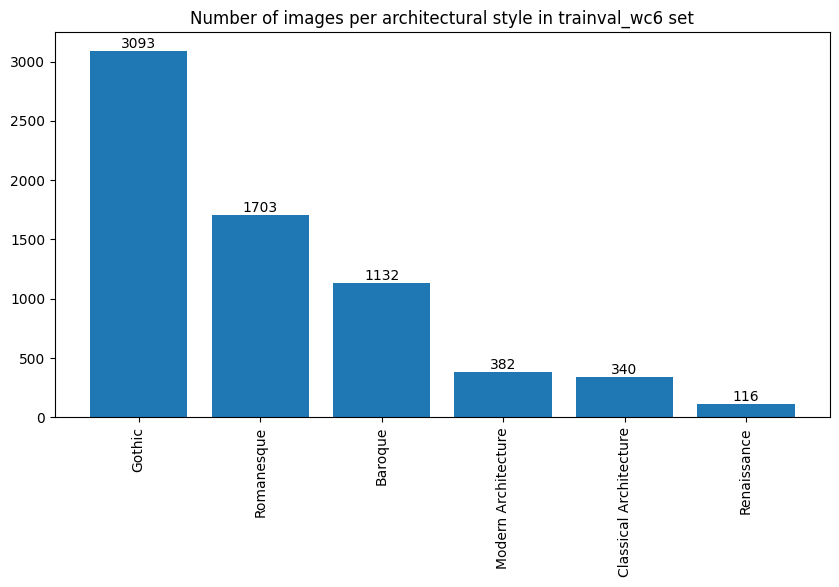

,img_name,parent_id,parent_name
0,Q1415669_wd1.jpg,Q840829,Baroque
1,Q12030410_wd0.jpg,Q840829,Baroque
2,Q12031051_wd0.jpg,Q840829,Baroque
3,Q16320906_wd1.jpg,Q840829,Baroque
4,Q223413_wd0.jpg,Q840829,Baroque


(306, 3)

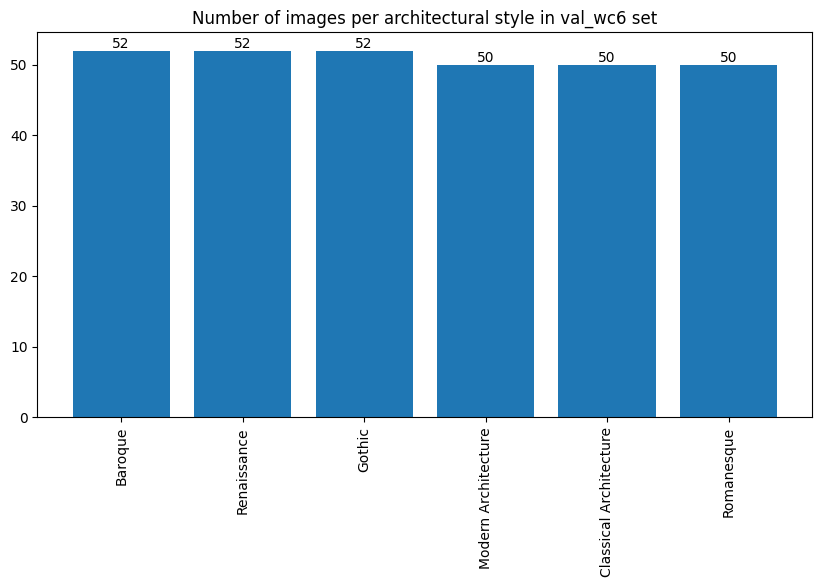

In [15]:
# On crée un objet Subset pour chaque fichier texte
test = Subset(test_txt, 'test_wc6')
train = Subset(train_txt, 'train_wc6')
trainval = Subset(trainval_txt, 'trainval_wc6')
val = Subset(val_txt, 'val_wc6')

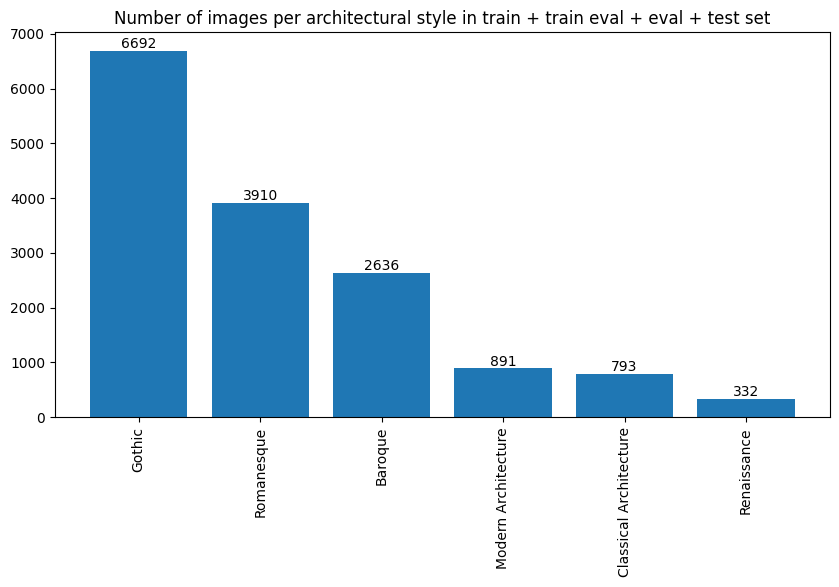

In [16]:
# On regroupe tous les sets dans un seul dataframe
df_concat_sets = pd.concat([test.get_df(), train.get_df(), trainval.get_df(), val.get_df()], ignore_index=True)

# On souhaite visualiser la distribution des styles architecturaux dans tous les sets
plot_style_distribution(df_concat_sets, 'train + train eval + eval + test')

### Etude statistique du set WC14

In [17]:
# Chemin vers le set wc14
wc14_txt = '../sets/csv/wc14.txt.csv'

In [18]:
# On crée un objet Subset pour le fichier texte
#wc14 = Subset(wc14_txt, 'wc14')

## Conclusion de l'étude statistique des sets de données proposés 

On observe dans les différentes études statistiques ci-dessus que la distribution des super-classes de styles architecturaux est très déséquilibrée.
On a en effet une trop grosse quantité d'images classées comme `Gothic` ou même `Romanesque` comparée à d'autres.
De fait, lorsque l'on entrainera un CNN sur ces sets, on court le risque qu'il prenne toutes les églises comme de style Gothique ou Romanesque, même celles qui ne le sont pas.

Il faut donc créer de nous même un set plus équilibré.

## Création d'un dataset plus équilibré à partir de WC6

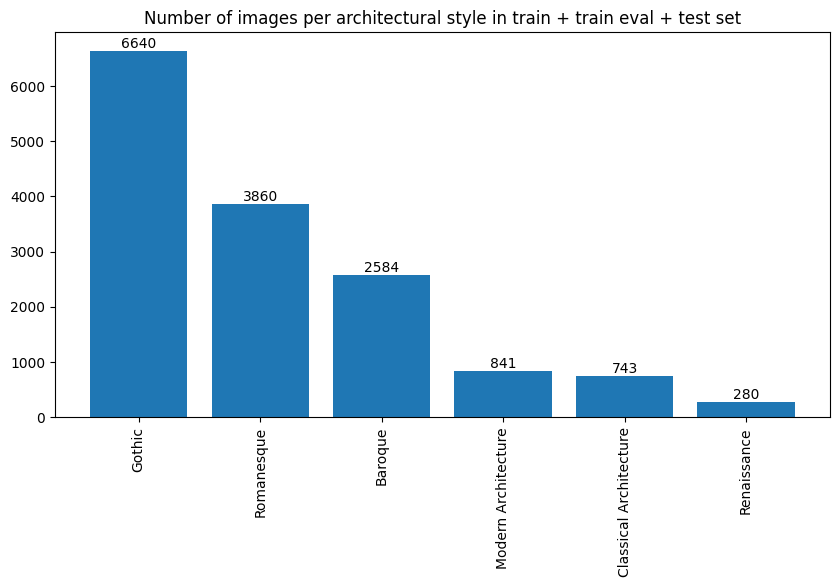

In [19]:
# On souhaite créer un dataset plus équilibré à partir des différents Subsets de WC6
# On va donc concaténer dans un nouveau dataframe les sets de train, trainval et test de wc6
# On n'agrège pas la classe gothique pour qu'elle ne soit pas surreprésentée par rapport aux autres classes

# On créé un dataframe test+trainval+train de wc6
df_wc6_all = pd.concat([test.get_df(), train.get_df(), trainval.get_df()], ignore_index=True)

# statistiques sur le nombre d'images par style architectural
plot_style_distribution(df_wc6_all, 'train + train eval + test')


(9616, 3)

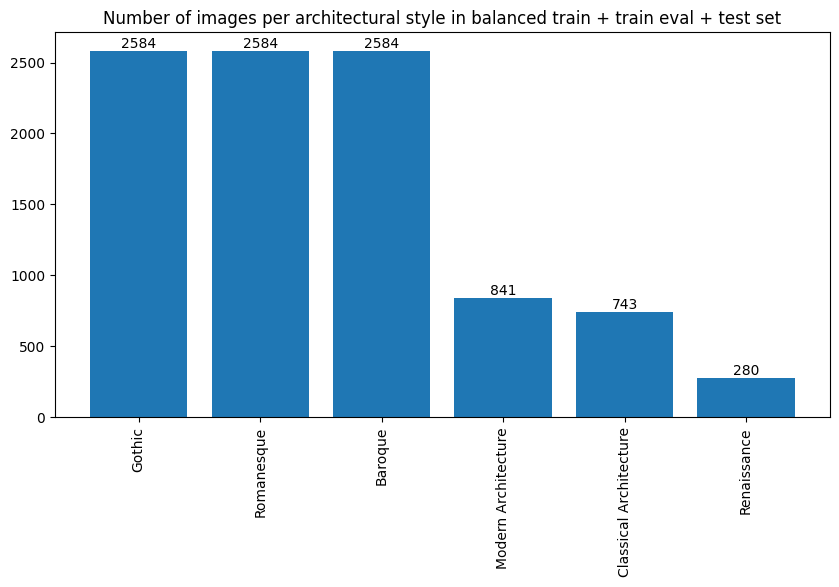

In [20]:
# On souhaite équilibre le dataset pour que :
# - Gothique : même nombre d'images que Baroque
# - Romanesque : même nombre d'images que Baroque

# Il y a 2584 images de style Baroque, on retire donc :
# - 6640 - 2584 = 4056 images de style Gothique
# - 3860 - 2584 = 1276 images de style Romanesque

# On retire donc 4056 images de style Gothique et 1276 images de style Romanesque

# On crée un dataframe contenant les images de style Gothique
df_gothic = df_wc6_all[df_wc6_all['parent_name'] == 'Gothic']

# On crée un dataframe contenant les images de style Romanesque
df_romanesque = df_wc6_all[df_wc6_all['parent_name'] == 'Romanesque']

# On crée un dataframe contenant les images de style Baroque
df_baroque = df_wc6_all[df_wc6_all['parent_name'] == 'Baroque']

# On crée un dataframe contenant les images de style Renaissance
df_renaissance = df_wc6_all[df_wc6_all['parent_name'] == 'Renaissance']

# On crée un dataframe contenant les images de style Modern
df_modern = df_wc6_all[df_wc6_all['parent_name'] == 'Modern Architecture']

# On crée un dataframe contenant les images de style Classical
df_classical = df_wc6_all[df_wc6_all['parent_name'] == 'Classical Architecture']

# On retire 4056 images de style Gothique
df_gothic = df_gothic.iloc[4056:]
# On retire 1276 images de style Romanesque
df_romanesque = df_romanesque.iloc[1276:]

# On concatène les dataframes
df_wc6_balanced = pd.concat([df_gothic, df_romanesque, df_baroque, df_renaissance, df_modern, df_classical], ignore_index=True)
display(df_wc6_balanced.shape)

# On sauvegarde le dataframe dans un fichier csv sans la colonne parent_name et sans header
df_wc6_balanced.to_csv('../sets/csv/wc6_balanced.csv', index=False,header=False, columns=['img_name', 'parent_id'])

# On souhaite visualiser la distribution des styles architecturaux dans le nouveau set
plot_style_distribution(df_wc6_balanced, 'balanced train + train eval + test')



,img_name,parent_id,parent_name
0,Q16857043_wd0.jpg,Q176483,Gothic
1,Q26869615_wd0.jpg,Q176483,Gothic
2,Q2956865_wd0.jpg,Q176483,Gothic
3,Q3584272_wd0.jpg,Q176483,Gothic
4,Q923396_wd0.jpg,Q176483,Gothic


(9616, 3)

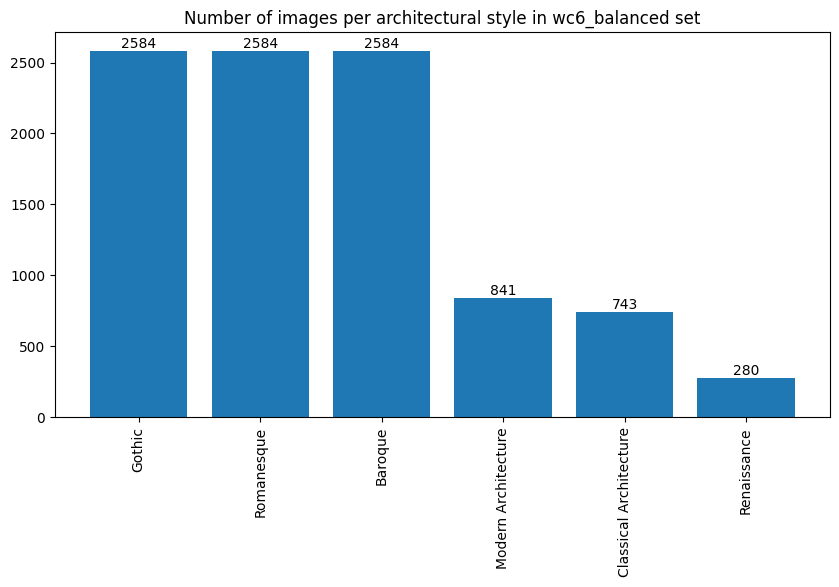

(9616, 3)

In [21]:
# On sauvegarde le dataframe dans un fichier texte contenant :
# {nom du fichier image} {id du style architectural}
# Et sans la collone parent_name

# On crée un objet Subset pour le fichier texte
wc6_balanced = Subset('../sets/csv/wc6_balanced.csv', 'wc6_balanced')
display(wc6_balanced.get_df().shape)


